In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

In [2]:
# CONSTANTS
DISPSIZE = (2500, 1400) # Display Resolution
MAXIMAL_DISTANCE = 25 # Eucledian Distance Fixation Calculation (Dispersion)
MINIMAL_DURATION = 50 # Minimal duration to be considered a fixation in milliseconds (typically 50 - 200)

def prepare_raw_data(gazeData, dataset):
    if gazeData.empty:
        print("Warning: gazeData is empty. Skipping processing.")
        return

    gazeData = filter_valid_entries(gazeData)
    gazeData = get_xy_coordinates(gazeData)
    gazeData = compute_mean_gaze_point(gazeData)
    gazeData = filterOffDisplayValues(gazeData)
    timestamps = getTimestampsInMilliseconds(gazeData)
    time = pd.Series(timestamps)
    gazeData = gazeData.assign(Timestamp=time.values)
    gazeData.reset_index()

    x_gazePoints, width = getXGazePointsAsPixel(gazeData)
    y_gazePoints, height = getYGazePointsAsPixel(gazeData)
    s = pd.Series(x_gazePoints)
    t = pd.Series(y_gazePoints)
    gazeData = gazeData.assign(PixelPointX=s.values)
    gazeData = gazeData.assign(PixelPointY=t.values)
    gazeData = remove_noise_df(gazeData)
    gazeData = calculate_isd(gazeData)
    gazeData = add_velocity_df(gazeData)

    gazeData.to_csv(dataset, index=False, na_rep='NaN')

def get_xy_coordinates(dataframe):
    def process_cell(cell_value):
        cell_value = cell_value.strip('()')  
        values = cell_value.split(',')  
        return [float(value) for value in values]  
        
    dataframe['left_gaze_point_on_display_area'] = dataframe['left_gaze_point_on_display_area'].apply(process_cell)
    dataframe['left_gaze_point_x'] = dataframe['left_gaze_point_on_display_area'].apply(lambda x: x[0])
    dataframe['left_gaze_point_y'] = dataframe['left_gaze_point_on_display_area'].apply(lambda x: x[1])
        
    dataframe['right_gaze_point_on_display_area'] = dataframe['right_gaze_point_on_display_area'].apply(process_cell)

    dataframe['right_gaze_point_x'] = dataframe['right_gaze_point_on_display_area'].apply(lambda x: x[0])
    dataframe['right_gaze_point_y'] = dataframe['right_gaze_point_on_display_area'].apply(lambda x: x[1])

    return dataframe

def event_detecting_smoothing(csv_file):
    event_df = pd.read_csv(csv_file)
    if event_df.empty:
        print("Warning: event_df is empty. Skipping processing.")
        return
    else:
        gazeData = mark_events_saccade_blink_noise(csv_file)
        gazeData = smooth_gaze_data(gazeData)
        gazeData.to_csv(csv_file, index=False, na_rep='NaN')

def get_fixations(csv_file):
    gazeData = pd.read_csv(csv_file)
    timestamps = getTimestampsInMilliseconds(gazeData)
    x_gazePoints = gazeData.SmoothPixelPointX
    y_gazePoints = gazeData.SmoothPixelPointY
    fixations_all_data = FilterDataWithFixations_weighted_mean(x_gazePoints, y_gazePoints, timestamps, mindur=50)
    fixations = []
    for fixation_data in fixations_all_data:
        start_time, end_time, duration, mean_x, mean_y, _ = fixation_data  # Ignore fixation points
        fixations.append([start_time, end_time, duration, mean_x, mean_y])
    return fixations



''' Fixation Algorithm'''

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y


def calculate_distance(point1, point2):
    # Calculate the Euclidean distance between two points
    return ((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2) ** 0.5

def calculate_weighted_mean(points):
    # Calculate the weighted mean of a list of points
    n = len(points)
    weighted_x_sum = sum((i + 1) * point.x for i, point in enumerate(points))
    weighted_y_sum = sum((i + 1) * point.y for i, point in enumerate(points))
    total_weight = (n * (n + 1)) / 2  # Sum of weights from 1 to n

    if total_weight == 0:
        return None  # Avoid division by zero

    mean_x = weighted_x_sum / total_weight
    mean_y = weighted_y_sum / total_weight

    return Point(mean_x, mean_y)

def FilterDataWithFixations_weighted_mean(x, y, time, saccade_threshold=MAXIMAL_DISTANCE, maxdist=MAXIMAL_DISTANCE, mindur=MINIMAL_DURATION):
    fixations = []

    current_fixation = []

    for i in range(len(x)):
        current_point = Point(x[i], y[i])

        if not current_fixation:
            current_fixation.append(current_point)
            continue

        last_fixation_point = current_fixation[-1]
        distance_to_current = calculate_distance(current_point, last_fixation_point)

        if distance_to_current < saccade_threshold:
            current_fixation.append(current_point)
        else:
            if current_fixation:
                # Check if the current fixation is valid (meets duration criteria)
                start_time = time[i - len(current_fixation)]
                end_time = time[i - 1]
                duration = end_time - start_time
                if duration >= mindur:
                    weighted_mean = calculate_weighted_mean(current_fixation)
                    if weighted_mean is not None:
                        fixations.append([start_time, end_time, duration, weighted_mean.x, weighted_mean.y, current_fixation])
                current_fixation = []

    # Check if there's any remaining fixation
    if current_fixation:
        start_time = time[len(x) - len(current_fixation)]
        end_time = time[-1]
        duration = end_time - start_time
        if duration >= mindur:
            weighted_mean = calculate_weighted_mean(current_fixation)
            if weighted_mean is not None:
                fixations.append([start_time, end_time, duration, weighted_mean.x, weighted_mean.y, current_fixation])

    return fixations


''' Helper Functions'''

# Monoccular
def filter_valid_entries(dataframe):
    valid_rows = dataframe[(dataframe['left_gaze_point_validity'] == 1) | (dataframe['right_gaze_point_validity'] == 1)]
    return valid_rows


def compute_mean_gaze_point(dataframe):
    actualGazePointX = []
    actualGazePointY = []

    for index, row in dataframe.iterrows():
        leftX = row['left_gaze_point_x']
        leftY = row['left_gaze_point_y']
        rightX = row['right_gaze_point_x']
        rightY = row['right_gaze_point_y']

        if not np.isnan(leftX) and not np.isnan(leftY) and not np.isnan(rightX) and not np.isnan(rightY):
            actualX = (leftX + rightX) / 2
            actualY = (leftY + rightY) / 2
        elif np.isnan(leftX) and np.isnan(leftY):
            actualX = rightX
            actualY = rightY
        elif np.isnan(rightX) and np.isnan(rightY):
            actualX = leftX
            actualY = leftY

        actualGazePointX.append(actualX)
        actualGazePointY.append(actualY)

    s = pd.Series(actualGazePointX)
    t = pd.Series(actualGazePointY)
    dataframe = dataframe.assign(ActualGazePointX=s.values)
    dataframe = dataframe.assign(ActualGazePointY=t.values)
    return dataframe


#Remove all off Display values
def filterOffDisplayValues(dataframe):

    inboundAll = dataframe[dataframe['ActualGazePointX'] <= 1]
    inboundAll = inboundAll[inboundAll['ActualGazePointX'] >= 0]

    inboundAll = inboundAll[inboundAll['ActualGazePointY'] <= 1]
    inboundAll = inboundAll[inboundAll['ActualGazePointY'] >= 0]

    return inboundAll


def getTimestampsInMilliseconds(dataframe):
    time = dataframe.device_time_stamp
    # time = dataframe.Timestamp
    time.reset_index(drop=True, inplace=True)
    t_temp = []

    if not time.empty:
        initalTime = time.iloc[0] / 1000
        for t in time:
            t_temp.append(t / 1000 - initalTime)
    else:
        print("Warning: time Series is empty. Returning an empty list.")

    return t_temp

def getXGazePointsAsPixel(dataframe):
    # user32 = ctypes.windll.user32
    # width = user32.GetSystemMetrics(0)
    # print(width)
    width = DISPSIZE[0]
    # width =  2560 #2048 #412
    x_temp = []
    actualX = dataframe['ActualGazePointX']
    for x in actualX[0:]:
        x_temp.append(round(x*width))
        # x_temp.append(x * width)
    return x_temp, width


def getYGazePointsAsPixel(dataframe):
    # user32 = ctypes.windll.user32
    # height = user32.GetSystemMetrics(1)
    # print(height)
    height = DISPSIZE[1]
    # height = 1440 #1152 #1440 #915
    y_temp = []
    actualY = dataframe['ActualGazePointY']
    for y in actualY[0:]:
        y_temp.append(round(y*height))
        # y_temp.append(y * height)
    return y_temp, height


def calculate_isd(df):
    df['InterSampleDuration_DS'] = df['device_time_stamp'].diff().fillna(0) / 1000
    return df

def remove_noise_df(dataframe):
    gazePointX = dataframe['PixelPointX'].tolist()
    gazePointY = dataframe['PixelPointY'].tolist()
    # threshold = 0.97 degrees X; 1.17 degrees Y on a 2560x1440 disp at 60cm-65cm distance
    noNoiseGazePointX = replace_outliers_with_median(gazePointX, threshold=50)
    noNoiseGazePointY = replace_outliers_with_median(gazePointY, threshold=60)

    dataframe['PixelPointX'] = noNoiseGazePointX
    dataframe['PixelPointY'] = noNoiseGazePointY

    return dataframe

def replace_outliers_with_median(points, threshold, window_size=3):
    num_points = len(points)
    new_points = []

    for i in range(len(points)):
        if i < window_size or i >= num_points - window_size:
            # not enough points
            new_points.append(points[i])
        else:
            # Euclidean to points within the +2 and -2 window
            distances = []
            for j in range(i - window_size, i + window_size + 1):
                distance = np.linalg.norm(points[i] - points[j])
                distances.append(distance)

            # distance greater than the threshold -->  outlier
            if np.mean(distances) > threshold:
                # Replace the outlier point with the median of the points within the window
                median_point = np.median([points[j] for j in range(i - window_size, i + window_size + 1) if j != i],
                                         axis=0)
                new_points.append(median_point)

            else:
                new_points.append(points[i])

    return new_points

def add_velocity_df(gazeData, sampling_frequency=250):
    # timestamps = gazeData.Timestamp
    timestamps = getTimestampsInMilliseconds(gazeData)
    x_gazePoints = gazeData.PixelPointX
    y_gazePoints = gazeData.PixelPointY
    velocity = calculate_velocity(x_gazePoints, y_gazePoints, timestamps, sampling_frequency)
    # print(len(velocity), len(gazeData))
    if len(velocity) == len(gazeData) - 1:
        velocity = np.insert(velocity, 0, 0)
    elif len(velocity) == len(gazeData):
        velocity = velocity
        # s = pd.Series(velocity)
        # gazeData = gazeData.assign(Velocity=s.values)
    gazeData['Velocity'] = velocity

    return gazeData

def calculate_velocity(x, y, timestamps, sampling_frequency=250):
    time_intervals = np.diff(timestamps) / 1000  # Convert milliseconds to seconds

    if np.any(time_intervals == 0):
        print("Warning: Velocity calculation forced.")
        # force replace zero time intervals with 4ms because ET error, should be changed for different sampliong
        time_intervals[time_intervals == 0] = 4

    velocity = np.sqrt(np.diff(x)**2 + np.diff(y)**2) / (time_intervals * sampling_frequency)
    velocity = np.insert(velocity, 0, 0)

    return velocity


def mark_events_saccade_blink_noise(csv_file):
    event_df = pd.read_csv(csv_file)
    if event_df.empty:
        print("Warning: gazeData is empty. Skipping processing.")
        return

    else:
        event_df['Event_Type'] = 'Unknown'

        saccade_start = False
        saccade_end = False

        for i in range(len(event_df)):
            if i < 0:
                continue

            inter_sample_duration = event_df.at[i, 'InterSampleDuration_DS']
            velocity = event_df.at[i, 'Velocity']

            if 99 < inter_sample_duration < 200:
                event_df.at[i, 'Event_Type'] = 'Blink_End'
            elif inter_sample_duration > 200:
                event_df.at[i, 'Event_Type'] = 'Noise_End'
            else:
                if velocity > 30 and not saccade_start:
                    event_df.at[i, 'Event_Type'] = 'Saccade_Start'
                    saccade_start = True
                    saccade_end = False

                    # Check if the next row exists
                    if i + 1 < len(event_df):
                        i = i + 1

                if saccade_start and i + 1 < len(event_df) and event_df.at[i + 1, 'Velocity'] <= 30 and not saccade_end:
                    event_df.at[i-1, 'Event_Type'] = 'Saccade_End'
                    saccade_start = False
                    saccade_end = True

                if saccade_start and not saccade_end:
                    event_df.at[i, 'Event_Type'] = 'Saccade'

        for i in range(len(event_df)):
            if i == 0:
                continue
            if event_df.at[i, 'Event_Type'] == 'Saccade_End' and event_df.at[i - 1, 'Event_Type'] == 'Saccade_Start':
                event_df.at[i, 'Event_Type'] = 'Noise'
                event_df.at[i - 1, 'Event_Type'] = 'Noise'
            if event_df.at[i, 'Event_Type'] == 'Saccade_End' and event_df.at[i - 1, 'Event_Type'] != 'Saccade':
                event_df.at[i, 'Event_Type'] = 'Noise'

        return event_df



def smooth_gaze_data(dataframe):
    if dataframe.empty:
        print("Warning: gazeData is empty. Skipping processing.")
        return

    gazePointX = dataframe['PixelPointX'].tolist()
    gazePointY = dataframe['PixelPointY'].tolist()
    eventType = dataframe['Event_Type']

    window_start = 0
    i = 0

    while i < len(dataframe):
        if eventType[i] == 'Saccade_Start':
            window_end = i - 1
            if window_start <= window_end:

                noNoiseGazePointX = apply_filter(gazePointX[window_start:window_end + 1])
                noNoiseGazePointY = apply_filter(gazePointY[window_start:window_end + 1])

                j = i + 1
                while j < len(dataframe) and eventType[j] != 'Saccade_End':
                    j += 1

                gazePointX[window_start:window_end+1] = noNoiseGazePointX
                gazePointY[window_start:window_end+1] = noNoiseGazePointY

                window_start = j - 1 # Early Onset of Filtering to avoid problem stated at func start

            i = window_start
        else:
            i += 1

    if window_start < len(dataframe):
        noNoiseGazePointX = apply_filter(gazePointX[window_start:])
        noNoiseGazePointY = apply_filter(gazePointY[window_start:])
        gazePointX[window_start:] = noNoiseGazePointX
        gazePointY[window_start:] = noNoiseGazePointY

    dataframe['SmoothPixelPointX'] = gazePointX
    dataframe['SmoothPixelPointY'] = gazePointY

    return dataframe


def apply_filter(gazePoints):
    window_length = 4
    filteredPoints = []
    gaussian_weight_func = gaussian_filter(window_length)
    i = 0  # Set i = 0 before while loop

    while i < len(gazePoints):
        if i < window_length:
            # window_data = gazePoints[i:i + window_length]
            # filteredPoints.append(np.median(window_data, axis=0))
            filteredPoints.append(gazePoints[i])
        else:
            temp_points = gazePoints[(i - window_length + 1):(i + 1)]
            weighted_avg = np.average(a=temp_points, weights=gaussian_weight_func, axis=0)
            filteredPoints.append(weighted_avg)
        i = i + 1  # Increment i within loop
    return filteredPoints


def gaussian_filter(window_length):
    gaze_window_list = np.arange(1, window_length + 1)
    gauss_list = []
    for x in gaze_window_list:
        x = math.e ** -((x ** 2)/(2 * (65)))
        gauss_list.append(x)
    gauss_list.reverse()
    return gauss_list

In [3]:
csv_file_path = 'gaze_data.csv'
proccessed_csv_file_path = 'proccessed_gaze_data.csv'
gaze_df = pd.read_csv(csv_file_path)
prepare_raw_data(gaze_df, proccessed_csv_file_path)
event_detecting_smoothing(proccessed_csv_file_path)
    
fixations = get_fixations(proccessed_csv_file_path)
#print(f'List of Fixations (start time, end time, dur, x, y): {fixations}')
print(f'Total Fixation Duration = {sum(fix[2] for fix in fixations)} ms, Number of Fixations = {len(fixations)}')

/var/folders/hm/xkjzyd4d26l9g8h9y20nxxsc0000gn/T/ipykernel_78681/3390124652.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['left_gaze_point_on_display_area'] = dataframe['left_gaze_point_on_display_area'].apply(process_cell)
/var/folders/hm/xkjzyd4d26l9g8h9y20nxxsc0000gn/T/ipykernel_78681/3390124652.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['left_gaze_point_x'] = dataframe['left_gaze_point_on_display_area'].apply(lambda x: x[0])
/var/folders/hm/xkjzyd4d26l9g8h9y20nxxsc00

Total Fixation Duration = 49925.999000000535 ms, Number of Fixations = 135


# newly added functions

In [4]:
def caluclate_fixation_count_AOI(aoi, fixations):
    aoi_x, aoi_y, aoi_w, aoi_h = aoi
    counts = 0
    for element in fixations:
        _, _, _, fix_x, fix_y = element
        if aoi_x <= fix_x < aoi_x + aoi_w and aoi_y <= fix_y < aoi_y + aoi_h:
            counts = counts + 1
    return counts

def calculate_fixation_rate_AOI(fixation_counts, num_fixations):
    ratios = []
    for count in fixation_counts:
        ratio = count / num_fixations
        ratios.append(ratio)
    return ratios

def calculate_fixation_spatial_density(cells, fixations):
    cell_hit_count = 0
    for key, value in cells.items():
        cell_x, cell_y, cell_w, cell_h = value
        found = 0
        for element in fixations:
            _, _, _, fix_x, fix_y = element
            if cell_x <= fix_x < cell_x + cell_w and cell_y <= fix_y < cell_y + cell_h and found == 0:
                cell_hit_count = cell_hit_count + 1
                found = 1
    return cell_hit_count

def calculate_fixation_time(aois, fixations):
    aois_fixation_times = []
    for key, value in aois.items():
        aoi_x, aoi_y, aoi_w, aoi_h = value
        fixation_time = 0
        for element in fixations:
            _, _, duration, fix_x, fix_y = element
            if aoi_x <= fix_x < aoi_x + aoi_w and aoi_y <= fix_y < aoi_y + aoi_h:
                fixation_time = fixation_time + duration
        aois_fixation_times.append(fixation_time)
    return aois_fixation_times

def calculate_saccades(velocity_threshold, fixations):
    saccades = []
    for i in range(1, len(fixations)):
        start_time_p, end_time_p, _ , fix_x_p, fix_y_p = fixations[i-1]
        start_time_c, end_time_c, _ , fix_x_c, fix_y_c = fixations[i] 

        dx = fix_x_c - fix_x_p
        dy = fix_y_c - fix_y_p
        duration = start_time_c - end_time_p
        velocity = math.sqrt(dx**2 + dy**2) / duration

        if velocity >= velocity_threshold:
            saccades.append((end_time_p, start_time_c, duration, dx, dy, velocity))
    return saccades

# declaring AOIs and GRIDs

In [5]:
# creating AOIs
AOIs = {
    "AOI_1" : [0, 0, 1250, 280],
    "AOI_2" : [0, 280, 1250, 280],
    "AOI_3" : [0, 560, 1250, 280],
    "AOI_4" : [0, 840, 1250, 280],
    "AOI_5" : [0, 1120, 1250, 280],
    "AOI_6" : [1250, 0, 1250, 280],
    "AOI_7" : [1250, 280, 1250, 280],
    "AOI_8" : [1250, 560, 1250, 280],
    "AOI_9" : [1250, 840, 2500, 280],
    "AOI_10" : [1250, 1120, 1250, 280]
}

# creating grid cells
cells = {}
cell_counts = 1
grid_x = 0
grid_width = 250
grid_height = 140
for row in range(10):
    grid_y = 0
    for col in range(10):
        cell = f'cell_{cell_counts}'
        cells[cell] = [grid_x, grid_y, grid_width, grid_height]
        grid_y = grid_y + 14
        cell_counts = cell_counts + 1
    grid_x = grid_x + 25

# code starts from here
# calculating number of fixations and cells
total_fixations = len(fixations)
total_cells = len(cells)

# fixation counts

In [6]:
# calculating fixations counts per AOI
print("Fixation Counts per AOI : ")
fixations_counts_aois = []
for key, value in AOIs.items():
    fixation_counts = caluclate_fixation_count_AOI(value, fixations)
    print(f'For {key} fixation counts : {fixation_counts}')
    fixations_counts_aois.append(fixation_counts)

Fixation Counts per AOI : 
For AOI_1 fixation counts : 33
For AOI_2 fixation counts : 42
For AOI_3 fixation counts : 27
For AOI_4 fixation counts : 1
For AOI_5 fixation counts : 5
For AOI_6 fixation counts : 13
For AOI_7 fixation counts : 2
For AOI_8 fixation counts : 0
For AOI_9 fixation counts : 3
For AOI_10 fixation counts : 9


# fixation rates

In [7]:
print("Fixation Rates per AOI : ")
fixation_rates = calculate_fixation_rate_AOI(fixations_counts_aois, total_fixations)
for index, data in enumerate(AOIs.items()):
    key, _ = data
    print(f'For {key} fixation rates : {fixation_rates[index]}')

Fixation Rates per AOI : 
For AOI_1 fixation rates : 0.24444444444444444
For AOI_2 fixation rates : 0.3111111111111111
For AOI_3 fixation rates : 0.2
For AOI_4 fixation rates : 0.007407407407407408
For AOI_5 fixation rates : 0.037037037037037035
For AOI_6 fixation rates : 0.0962962962962963
For AOI_7 fixation rates : 0.014814814814814815
For AOI_8 fixation rates : 0.0
For AOI_9 fixation rates : 0.022222222222222223
For AOI_10 fixation rates : 0.06666666666666667


# Fixation Spatial Density

In [8]:
print("Fixation Spatial Density  : ")
fixation_spatial_density = calculate_fixation_spatial_density(cells, fixations) / total_cells
print(f"Fixation Spatial Density : {fixation_spatial_density}")

Fixation Spatial Density  : 
Fixation Spatial Density : 0.96


# average fixation duration

In [9]:
print("Average Fixation Duration  : ")
total_fixation_duration = sum(fix[2] for fix in fixations)
average_fixation_duration = total_fixation_duration / total_fixations
print(f"Average Fixation Duration  : {average_fixation_duration}")

Average Fixation Duration  : 
Average Fixation Duration  : 369.8222148148188


# fixations times

In [10]:
fixation_times = calculate_fixation_time(AOIs, fixations)

In [11]:
# printing fixation time per AOI
print("Fixation times per AOI  : ")
for index, data in enumerate(AOIs.items()):
    key, value = data
    fixation_time = fixation_times[index]
    print(f'For {key} fixation time : {fixation_time} ms')

Fixation times per AOI  : 
For AOI_1 fixation time : 11725.218000000226 ms
For AOI_2 fixation time : 18600.37700000021 ms
For AOI_3 fixation time : 11791.896999999764 ms
For AOI_4 fixation time : 183.33200000005309 ms
For AOI_5 fixation time : 1733.375 ms
For AOI_6 fixation time : 2825.05700000003 ms
For AOI_7 fixation time : 275.0030000000261 ms
For AOI_8 fixation time : 0 ms
For AOI_9 fixation time : 300.00800000003073 ms
For AOI_10 fixation time : 2491.732000000193 ms


# Ratio of ON-target:All-target Fixation Time (ROAFT) per AOI 

In [12]:
print("Ratio of ON-target:All-target Fixation Time (ROAFT) per AOI : ")
for index, data in enumerate(AOIs.items()):
    key, value = data
    fixation_time = fixation_times[index]
    roaft = fixation_time / total_fixation_duration
    print(f'For {key} ROAFT : {roaft}')

Ratio of ON-target:All-target Fixation Time (ROAFT) per AOI : 
For AOI_1 ROAFT : 0.23485194557649414
For AOI_2 ROAFT : 0.3725589346744972
For AOI_3 ROAFT : 0.23618750222703883
For AOI_4 ROAFT : 0.0036720747440637316
For AOI_5 ROAFT : 0.034718884643649923
For AOI_6 ROAFT : 0.056584886764108604
For AOI_7 ROAFT : 0.005508212264315896
For AOI_8 ROAFT : 0.0
For AOI_9 ROAFT : 0.006009053519390318
For AOI_10 ROAFT : 0.049908505586441367


# Average Duration of Relevant Fixations (ADRF) based on fixation count or time


### based on fixation time

In [13]:
relevent_aois = []
fixation_time_threshold = 2000 
for index, data in enumerate(AOIs.items()):
    if fixation_times[index] > fixation_time_threshold:
        relevent_aois.append(index)

relevent_aios_fixation_time = 0
for index in relevent_aois:
    relevent_aios_fixation_time = relevent_aios_fixation_time + fixation_times[index]
average_duration_of_relevant_fixations = relevent_aios_fixation_time / len(relevent_aois)
print(f"Average Duration of Relevant Fixations (ADRF) : {average_duration_of_relevant_fixations} ms")

Average Duration of Relevant Fixations (ADRF) : 9486.856200000086 ms


### based on fixation count

In [14]:
relevent_aois = []
fixation_count_threshold = 10
for index, data in enumerate(AOIs.items()):
    if fixations_counts_aois[index] > fixation_count_threshold:
        relevent_aois.append(index)

relevent_aios_fixation_time = 0
for index in relevent_aois:
    relevent_aios_fixation_time = relevent_aios_fixation_time + fixation_times[index]
average_duration_of_relevant_fixations = relevent_aios_fixation_time / len(relevent_aois)
print(f"Average Duration of Relevant Fixations (ADRF) : {average_duration_of_relevant_fixations} ms")

Average Duration of Relevant Fixations (ADRF) : 11235.637250000058 ms


# Normalised Rate of Relevant Fixations (NRRF)

In [15]:
normalized_rate_of_relevant_fixations = average_duration_of_relevant_fixations / (total_fixation_duration/len(AOIs))
print(f"Normalised Rate of Relevant Fixations (NRRF) : {normalized_rate_of_relevant_fixations}")

Normalised Rate of Relevant Fixations (NRRF) : 2.2504581731053466


# saccade related metrices

### number of saccades

In [16]:
velocity_threshold = 10
saccades = calculate_saccades(velocity_threshold, fixations)
number_of_saccades = len(saccades)
print(f'Number of Saccades : {number_of_saccades}')

Number of Saccades : 32


### saccade duration

In [17]:
saccades_duration = sum(sample[2] for sample in saccades)
print(f'Total Saccades durations : {saccades_duration} ms')

Total Saccades durations : 2216.719000000041 ms


### average saccade duration

In [18]:
average_saccades_duration = saccades_duration / number_of_saccades
print(f'Average Saccade Duration : {average_saccades_duration} ms')

Average Saccade Duration : 69.27246875000128 ms


### backward saccades

In [19]:
backward_saccades = len([i for i in range(len(saccades)) if saccades[i][3] < 0 or saccades[i][4] < 0])
print(f'Total Number of Backward Saccades : {backward_saccades}')

Total Number of Backward Saccades : 27


### Regression Rate

In [20]:
regression_rate = backward_saccades / number_of_saccades
print(f'Regrassion Rate : {regression_rate}')

Regrassion Rate : 0.84375


# Fixation Plot

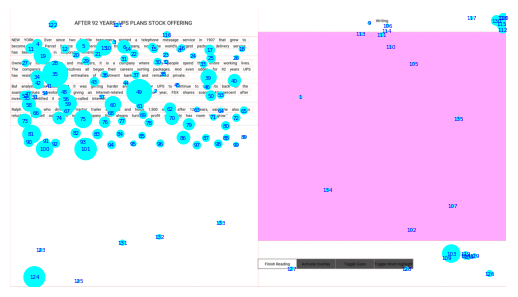

In [22]:
def generate_fixation_plot(image_path, fixations):
    img = Image.open(image_path)
    img = img.resize((2500, 1400), Image.LANCZOS)

    plt.imshow(img)
    ax = plt.gca()

    # Plot each fixation
    for idx, data in enumerate(fixations):
        _, _, duration, x, y = data
        circle = plt.Circle((x, y), duration/20, color='cyan', fill = True)  # Adjust circle size factor as needed
        ax.add_patch(circle)
        ax.text(x, y, str(idx + 1), color='blue', fontsize=4, ha='center', va='center')

        # Show the plot
    plt.axis('off')  # To turn off the axis
    plt.savefig('fixations.png',dpi=300)

# plot the fixations on the given image , save the overlayed image and show it     
image_path = 'Big Screen.png'
generate_fixation_plot(image_path, fixations)
image = Image.open('fixations.png')
image.show()

# scanpath plot

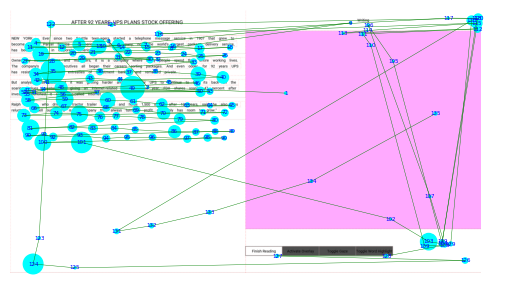

In [23]:
def generate_scanpath_plot(image_path, fixations):
    img = Image.open(image_path)
    img = img.resize((2500, 1400), Image.LANCZOS)

    plt.imshow(img)
    ax = plt.gca()

    # Plot the scan path (lines connecting fixation points)
    for i in range(len(fixations)-1):
        _, _, _, x1, y1 = fixations[i]
        _, _, _, x2, y2 = fixations[i+1]
        ax.plot([x1, x2], [y1, y2], color='green', linewidth=0.3) 

    # Plot each fixation
    for idx, data in enumerate(fixations):
        _, _, duration, x, y = data
        circle = plt.Circle((x, y), duration/20, color='cyan', fill = True)  # Adjust circle size factor as needed
        ax.add_patch(circle)
        ax.text(x, y, str(idx + 1), color='blue', fontsize=4, ha='center', va='center')

        # Show the plot
    plt.axis('off')  # To turn off the axis
    plt.savefig('scanpath.png',dpi=300)

# plot the scanpaths on the given image , save the overlayed image and show it     
image_path = 'Big Screen.png'
generate_scanpath_plot(image_path, fixations)
image = Image.open('scanpath.png')
image.show()